##Load the Data

In [8]:
import pandas as pd
import numpy as np
!pip install matplotlib


In [9]:
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv('/content/TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')

In [11]:
data.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


In [12]:
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])

In [13]:
data['utc_timestamp']

,utc_timestamp
0,2016-01-01 00:00:00+00:00
1,2016-01-01 01:00:00+00:00
2,2016-01-01 02:00:00+00:00
3,2016-01-01 03:00:00+00:00
4,2016-01-01 04:00:00+00:00
...,...
8779,2016-12-31 19:00:00+00:00
8780,2016-12-31 20:00:00+00:00
8781,2016-12-31 21:00:00+00:00
8782,2016-12-31 22:00:00+00:00


##Visualize The Data

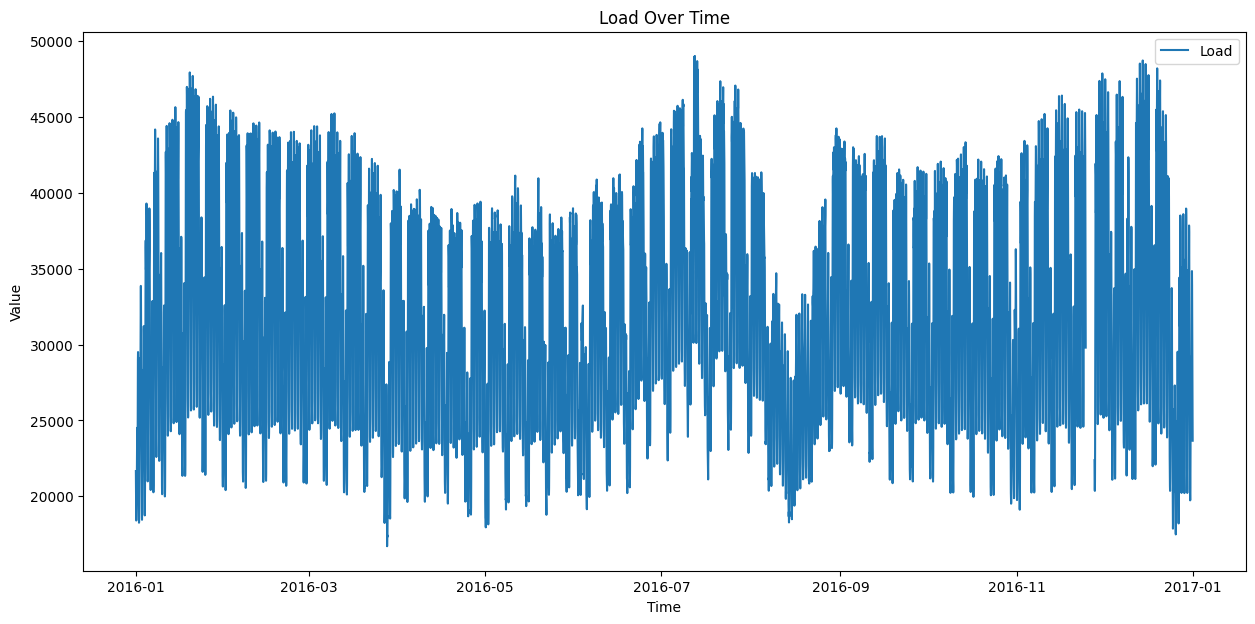

In [20]:
plt.figure(figsize = (15,7))
plt.plot(data['utc_timestamp'],data['IT_load_new'],label = 'Load')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load Over Time')
plt.show()

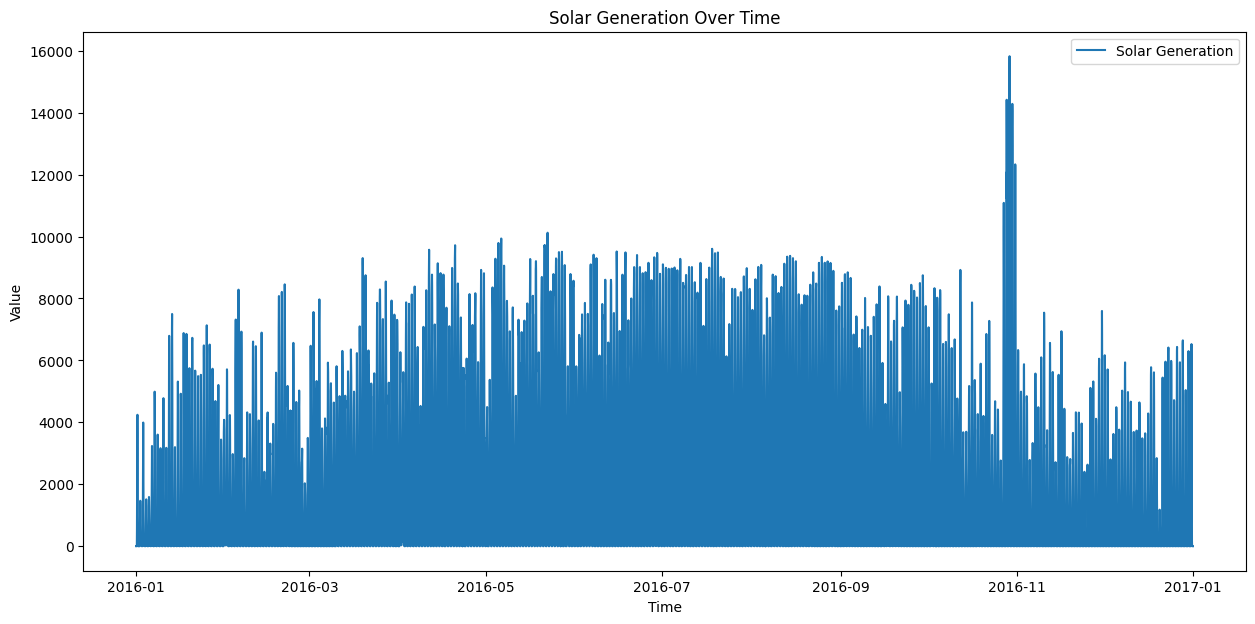

In [21]:
plt.figure(figsize = (15,7))
plt.plot(data['utc_timestamp'],data['IT_solar_generation'],label = 'Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Solar Generation Over Time')
plt.show()

The plot shows both the load and solar generation over time for the year 2016.

The load appears to have a cyclical pattern with peaks and valleys, possibly corresponding to daily patterns of electricity use.

The solar generation also shows a clear pattern, with generation during the day and no generation at night (as expected). The amount of solar generation also appears to fluctuate throughout the year, likely due to seasonal changes in sunlight.

**Augmented Dickey-Fuller test to check the *stationarity* of the time series**

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then reject the null hypothesis and infer that the time series is indeed stationary

## Handle missing values

In [22]:
data.isnull().sum()

,0
utc_timestamp,0
IT_load_new,72
IT_solar_generation,0


In [27]:
data['IT_load_new']=data['IT_load_new'].fillna(method='ffill')

<ipython-input-27-18c4465c4fbb>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['IT_load_new']=data['IT_load_new'].fillna(method='ffill')


In [29]:
data.isnull().sum()

,0
utc_timestamp,0
IT_load_new,0
IT_solar_generation,0


## Check for stationarity

In [30]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [32]:
# Perform test for 'IT_load_new'
print("ADF test for 'IT_load_new':")
adf_test(data['IT_load_new'])

# Perform test for 'IT_solar_generation'
print("\nADF test for 'IT_solar_generation':")
adf_test(data['IT_solar_generation'])

ADF test for 'IT_load_new':
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


### According to the Augmented Dickey-Fuller test:

For 'IT_load_new': The p-value is extremely small (much less than 0.05), so we reject the null hypothesis that the time series is non-stationary. Therefore, 'IT_load_new' can be considered ***stationary***.

For 'IT_solar_generation': The p-value is also very small (much less than 0.05), so we reject the null hypothesis. This means 'IT_solar_generation' can be considered ***stationary*** as well.

Since both series are stationary, we can proceed with building an ARIMA model for each of them.


### According to the ARIMA model
I is characterized by 3 terms: p, d, q

p is the order of the AR term (number of lags of Y to be used as predictors).

q is the order of the MA term (moving average).

d is the number of differencing required to make the time series stationary.

In our case, since the series are already stationary, d=0 for both series. We need to determine the optimal values for p and q. To do this, we'll look at the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots.


## Build ARIMA model for 'IT_load_new'

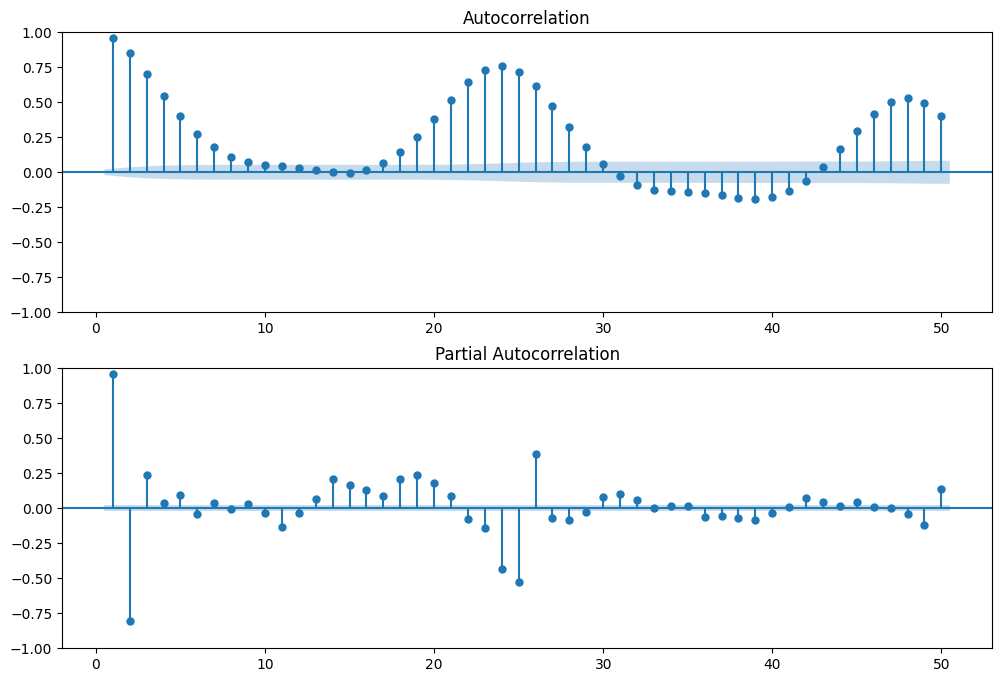

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_load_new'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_load_new'], lags=50, zero=False, ax=ax2)
plt.show()

From the ACF plot, we see a gradual decrease.

And from the PACF plot, there is a sharp drop after lag 2.

So, we can take p=2 and q=2 as our model parameters.

##Splitting Data for 'IT_load_new'

In [38]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(data['IT_load_new']) * 0.8)
train, test = data['IT_load_new'][:train_size], data['IT_load_new'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7714.952134850774

In [39]:
# Fit the ARIMA model
model2 = ARIMA(train, order=(2,1,2))
model_fit2 = model2.fit()

# Make predictions on the test set
predictions2 = model_fit2.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse2 = sqrt(mean_squared_error(test, predictions2))
rmse2

7993.849413715497

In [40]:
# Fit the ARIMA model
model3 = ARIMA(train, order=(2,2,2))
model_fit3 = model2.fit()

# Make predictions on the test set
predictions3 = model_fit3.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse3 = sqrt(mean_squared_error(test, predictions3))
rmse3

7993.849413715497

##(For IT_Load_new) Plotting Actual Values and Forecasted Values to visualize how well model is performing

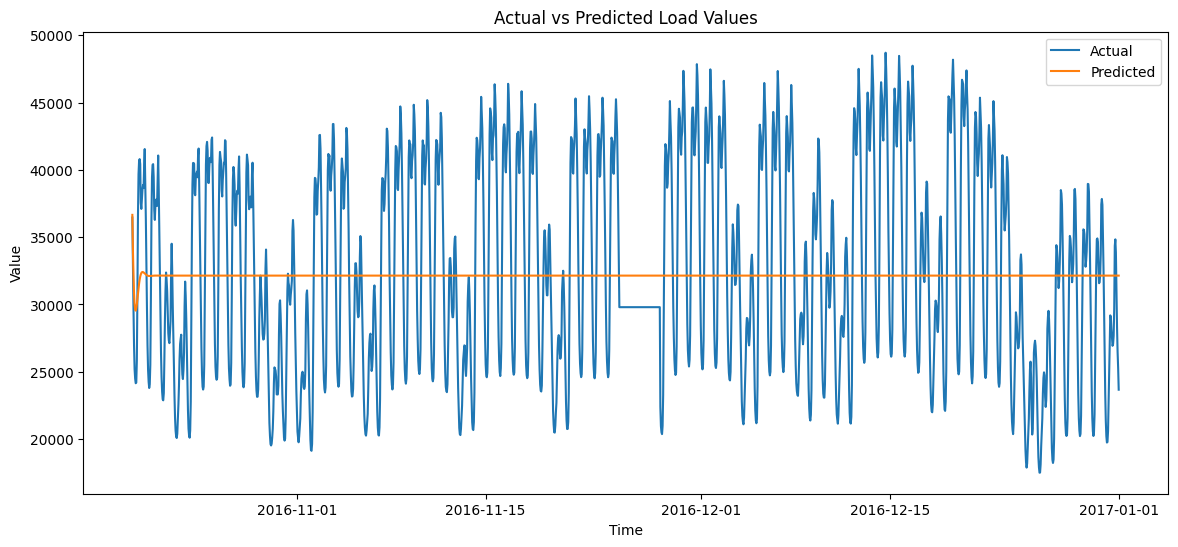

In [41]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

This discrepancy could be due to various factors such as inherent randomness in the data, the presence of other unaccounted influences, or simply the limitations of the ARIMA model. More complex models or additional data preprocessing might improve the results.

## Build ARIMA model for 'IT_solar_generation'

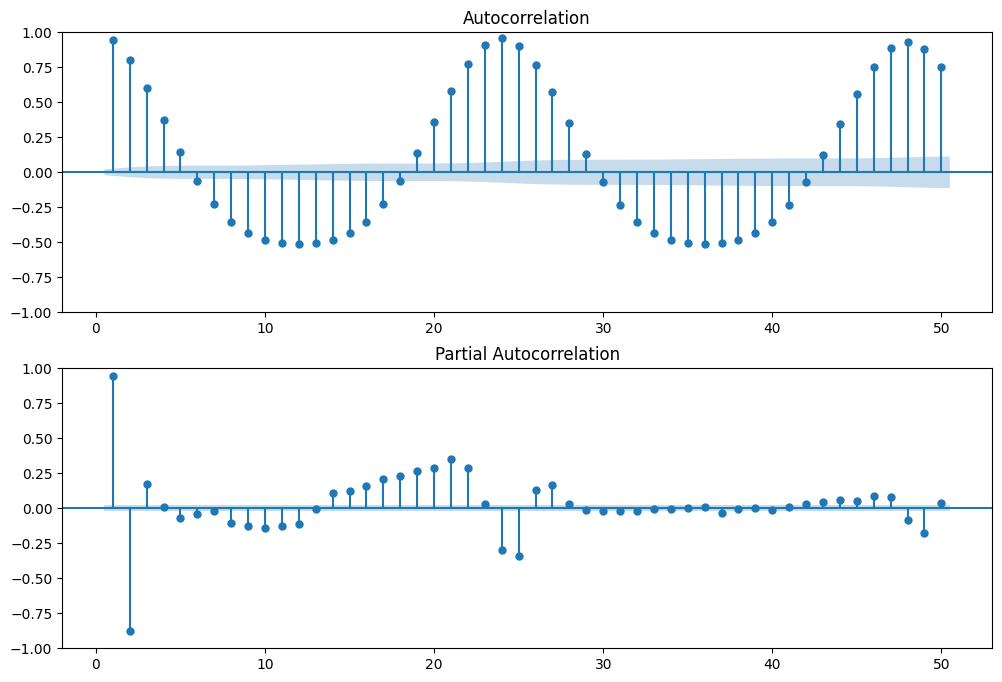

In [42]:
# Plot ACF and PACF for 'IT_solar_generation'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(data['IT_solar_generation'], lags=50, zero=False, ax=ax1)
plot_pacf(data['IT_solar_generation'], lags=50, zero=False, ax=ax2)
plt.show()


##Splitting Data for 'IT_solar_generation'

In [43]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(data['IT_solar_generation']) * 0.8)
train, test = data['IT_solar_generation'][:train_size], data['IT_solar_generation'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

2486.1507110911857

##(For IT_solaR_generation) Plotting Actual Values and Forecasted Values to visualize how well model is performing

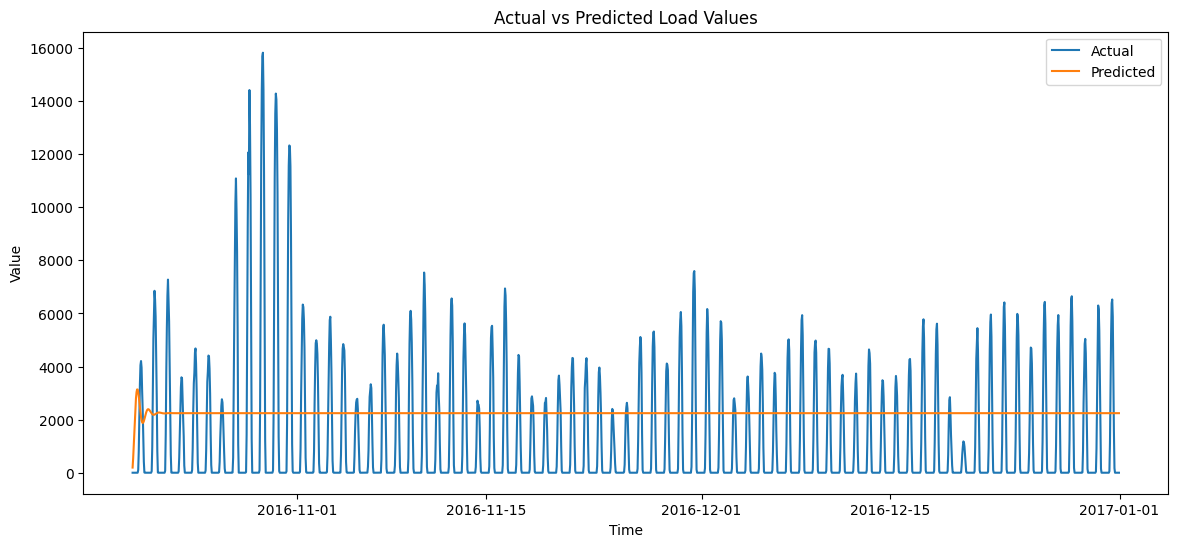

In [44]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(data['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(data['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

##Conclusion

The plot shows the actual versus predicted solar generation values for the test set. As with the load model, the ARIMA model seems to capture the general pattern of the time series data.